# Emotion Detection Model Training
This notebook trains a CNN model on an emotion dataset (FER-2013).

## Step 1: Setup

In [ ]:
# Install required packages
!pip install tensorflow==2.15.0 keras==2.15.0 opencv-python-headless==4.9.0.80 matplotlib numpy==1.26.4 Pillow==10.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninst

## Step 2: Import libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

## Step 3: Upload dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


## Step 4: Extract dataset

In [ ]:
import zipfile
import io
for zip_name in uploaded:
    with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as zip_ref:
        zip_ref.extractall("dataset")

# Paths
train_dir = 'dataset/dataset/train'
test_dir = 'dataset/dataset/test'

## Step 5: Load and preprocess data

In [ ]:
labels = {'angry': 0, 'happy': 1, 'sad': 2, 'neutral': 3, 'disgust': 4, 'fear': 5, 'surprise': 6}
X_train, y_train = [], []

for label in labels:
    path = os.path.join(train_dir, label)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48, 48))
        X_train.append(img)
        y_train.append(labels[label])

X_train = np.array(X_train).reshape(-1, 48, 48, 1) / 255.0
y_train = to_categorical(y_train, num_classes=len(labels))

X_test, y_test = [], []
for label in labels:
    path = os.path.join(test_dir, label)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48, 48))
        X_test.append(img)
        y_test.append(labels[label])

X_test = np.array(X_test).reshape(-1, 48, 48, 1) / 255.0
y_test = to_categorical(y_test, num_classes=len(labels))

## Data augmentation

### Subtask:
Create an `ImageDataGenerator` for data augmentation and a `ReduceLROnPlateau` callback.


**Reasoning**:
Instantiate ImageDataGenerators for training and validation, and a ReduceLROnPlateau callback.



In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator() # No augmentation for validation data, only rescaling.

# The rescaling is now handled by the ImageDataGenerator, so we don't need to do it here.
# X_train = X_train * 255.0
# X_test = X_test * 255.0


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

## Step 6: Build model

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Step 7: Train model

In [ ]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=val_datagen.flow(X_test, y_test, batch_size=32),
                    callbacks=[reduce_lr])
# loss: 1.0832 - accuracy: 0.5916 - val_loss: 0.9633 - val_accuracy: 0.6402

Epoch 1/50
898/898 [==============================] - 597s 661ms/step - loss: 2.0727 - accuracy: 0.2277 - val_loss: 2.3088 - val_accuracy: 0.2941 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - 579s 644ms/step - loss: 1.7383 - accuracy: 0.3018 - val_loss: 1.6663 - val_accuracy: 0.3470 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - 579s 645ms/step - loss: 1.5923 - accuracy: 0.3728 - val_loss: 1.4898 - val_accuracy: 0.4426 - lr: 0.0010
Epoch 4/50
898/898 [==============================] - 581s 647ms/step - loss: 1.4987 - accuracy: 0.4181 - val_loss: 1.5845 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 5/50
898/898 [==============================] - 589s 656ms/step - loss: 1.4446 - accuracy: 0.4434 - val_loss: 1.2882 - val_accuracy: 0.5106 - lr: 0.0010
Epoch 6/50
898/898 [==============================] - 596s 664ms/step - loss: 1.4190 - accuracy: 0.4544 - val_loss: 1.3056 - val_accuracy: 0.4985 - lr: 0.0010
Epoch 7/50
898/898 [==========================

## Step 8: Save model

In [ ]:
model.save("emotion_model.hdf5")
files.download("emotion_model.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plot accuracy

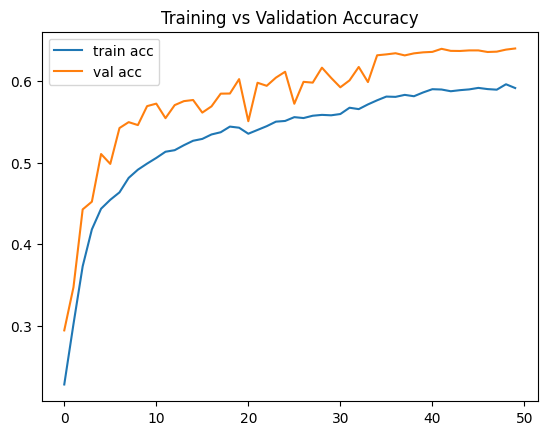

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

**Reasoning**:
Train the model using the data generator and the specified callback.

